In [1]:
!nvidia-smi

Thu Dec 26 22:42:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.43.02              Driver Version: 535.98       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   63C    P0              37W / 140W |    504MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pennylane as qml


from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2024-12-26 22:42:36.162415: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-26 22:42:36.324394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735227756.383122   10708 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735227756.399694   10708 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 22:42:36.537057: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Setting of the main hyper-parameters of the model


In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 5    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 50     # Size of the test dataset

SAVE_PATH = "/content/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

# Loading of the MNIST dataset


In [4]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

# Quantum circuit as a convolution kernel

We follow the scheme described in the introduction and represented in
the figure at the top of this demo.

We initialize a PennyLane `default.qubit` device, simulating a system of
$4$ qubits. The associated `qnode` represents the quantum circuit
consisting of:

1.  an embedding layer of local $R_y$ rotations (with angles scaled by a
    factor of $\pi$);
2.  a random circuit of `n_layers`;
3.  a final measurement in the computational basis, estimating $4$
    expectation values.


In [7]:
dev1 = qml.device("lightning.qubit", wires = 4)
dev2 = qml.device("default.qubit", wires = 4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

print(rand_params)
@qml.qnode(dev1)
def circuit1(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)), seed = None)


    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]


# qml.draw_mpl(circuit1, level=None, decimal = 1)([1,2,3,4])
# qml.draw_mpl(circuit1, level=None, decimal = 1)([2,3,4,5])

[[3.27025645 4.26552589 4.52786851 3.65693821]
 [3.37641558 4.76652254 0.66543712 2.9757192 ]
 [1.17076064 4.63019346 1.36062601 0.84960084]
 [2.03663802 0.94043493 1.39688648 2.42838189]
 [5.67119348 2.82711917 3.85199131 5.66962336]]


The next function defines the convolution scheme:

1.  the image is divided into squares of $2 \times 2$ pixels;
2.  each square is processed by the quantum circuit;
3.  the $4$ expectation values are mapped into $4$ different channels of
    a single output pixel.

::: note
::: title
Note
:::

This process halves the resolution of the input image. In the standard
language of CNN, this would correspond to a convolution with a
$2 \times 2$ *kernel* and a *stride* equal to $2.$
:::


In [12]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for i in range(4):
      cir = circuit1
      for j in range(0, 28, 2):
          for k in range(0, 28, 2):
              # Process a squared 2x2 region of the image with a quantum circuit
              q_results = cir(
                  [
                      image[j, k, 0],
                      image[j, k + 1, 0],
                      image[j + 1, k, 0],
                      image[j + 1, k + 1, 0]
                  ]
              )
              # Assign expectation values to different channels of the output pixel (j/2, k/2)

                  # out[j // 2, k // 2, c] = q_results[c]
              for c in range(4):
                out[j // 2, k // 2, i] += q_results[c]
              # out[j // 2, k // 2, i] /= 4
    return out

# Quantum pre-processing of the dataset

Since we are not going to train the quantum convolution layer, it is
more efficient to apply it as a \"pre-processing\" layer to all the
images of our dataset. Later an entirely classical model will be
directly trained and tested on the pre-processed dataset, avoiding
unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder `SAVE_PATH`. Once
saved, they can be directly loaded by setting `PREPROCESS = False`,
otherwise the quantum convolution is evaluated at each run of the code.



In [9]:
import os
os.environ["OMP_NUM_THREADS"] = "16"  # Replace 4 with your desired number of threads


In [13]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("\r{}/{}".format(idx + 1, n_train), end = '')
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("\r{}/{}".format(idx + 1, n_test), end = '')
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # # Save pre-processed images
    # np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    # np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# # Load pre-processed images
# q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
# q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50
Quantum pre-processing of test images:
50/50

Let us visualize the effect of the quantum convolution layer on a batch
of samples:


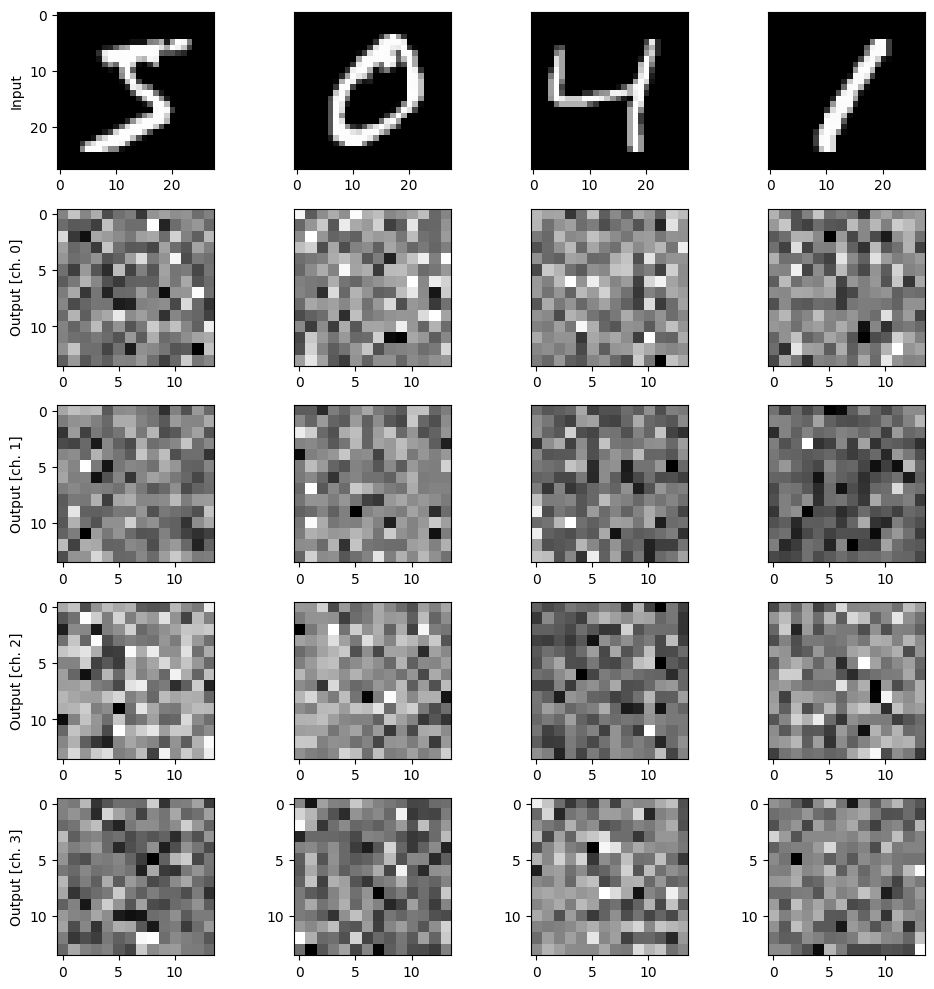

In [14]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Below each input image, the $4$ output channels generated by the quantum
convolution are visualized in gray scale.

One can clearly notice the downsampling of the resolution and some local
distortion introduced by the quantum kernel. On the other hand the
global shape of the image is preserved, as expected for a convolution
layer.


# Hybrid quantum-classical model

After the application of the quantum convolution layer we feed the
resulting features into a classical neural network that will be trained
to classify the $10$ different digits of the MNIST dataset.

We use a very simple model: just a fully connected layer with 10 output
nodes with a final *softmax* activation function.

The model is compiled with a *stochastic-gradient-descent* optimizer,
and a *cross-entropy* loss function.


In [49]:
train_images.shape

(5, 28, 28, 1)

In [50]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

def ClassicModel():
    """Initializes and returns a custom Keras CNN model ready to be trained on MNIST."""
    model = keras.models.Sequential([
        # First Convolutional layer
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

def QuanvModel():
    """Initializes and returns a custom Keras CNN model ready to be trained on MNIST."""
    model = keras.models.Sequential([
        # First Convolutional layer
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(14, 14, 4)),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model



# Training

We first initialize an instance of the model, then we train and validate
it with the dataset that has been already pre-processed by a quantum
convolution.


In [51]:
q_model = QuanvModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 - 3s - 1s/step - accuracy: 0.0000e+00 - loss: 2.8372 - val_accuracy: 0.0000e+00 - val_loss: 2.7045
Epoch 2/30
2/2 - 0s - 30ms/step - accuracy: 0.8000 - loss: 1.2979 - val_accuracy: 0.0000e+00 - val_loss: 3.3358
Epoch 3/30
2/2 - 0s - 24ms/step - accuracy: 0.6000 - loss: 0.9884 - val_accuracy: 0.0000e+00 - val_loss: 3.7362
Epoch 4/30
2/2 - 0s - 27ms/step - accuracy: 0.6000 - loss: 0.8411 - val_accuracy: 0.0000e+00 - val_loss: 3.6965
Epoch 5/30
2/2 - 0s - 36ms/step - accuracy: 1.0000 - loss: 0.5623 - val_accuracy: 0.0000e+00 - val_loss: 3.4626
Epoch 6/30
2/2 - 0s - 24ms/step - accuracy: 1.0000 - loss: 0.3246 - val_accuracy: 0.0000e+00 - val_loss: 3.2518
Epoch 7/30
2/2 - 0s - 29ms/step - accuracy: 1.0000 - loss: 0.1819 - val_accuracy: 0.2000 - val_loss: 3.1162
Epoch 8/30
2/2 - 0s - 34ms/step - accuracy: 1.0000 - loss: 0.0998 - val_accuracy: 0.4000 - val_loss: 3.0552
Epoch 9/30
2/2 - 0s - 22ms/step - accuracy: 1.0000 - loss: 0.0574 - val_accuracy: 0.4000 - val_loss: 3.0533
Epoch 10/30
2

In order to compare the results achievable with and without the quantum
convolution layer, we initialize also a \"classical\" instance of the
model that will be directly trained and validated with the raw MNIST
images (i.e., without quantum pre-processing).


In [45]:
c_model = ClassicModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
2/2 - 5s - 2s/step - accuracy: 0.0000e+00 - loss: 2.3735 - val_accuracy: 0.4000 - val_loss: 2.1891
Epoch 2/30
2/2 - 0s - 23ms/step - accuracy: 1.0000 - loss: 1.8873 - val_accuracy: 0.4000 - val_loss: 2.1258
Epoch 3/30
2/2 - 0s - 21ms/step - accuracy: 1.0000 - loss: 1.5827 - val_accuracy: 0.4000 - val_loss: 2.0856
Epoch 4/30
2/2 - 0s - 21ms/step - accuracy: 1.0000 - loss: 1.2649 - val_accuracy: 0.4000 - val_loss: 2.0636
Epoch 5/30
2/2 - 0s - 21ms/step - accuracy: 1.0000 - loss: 0.9371 - val_accuracy: 0.4000 - val_loss: 2.0659
Epoch 6/30
2/2 - 0s - 22ms/step - accuracy: 1.0000 - loss: 0.6406 - val_accuracy: 0.4000 - val_loss: 2.0890
Epoch 7/30
2/2 - 0s - 37ms/step - accuracy: 1.0000 - loss: 0.4030 - val_accuracy: 0.4000 - val_loss: 2.1315
Epoch 8/30
2/2 - 0s - 22ms/step - accuracy: 1.0000 - loss: 0.2404 - val_accuracy: 0.4000 - val_loss: 2.1862
Epoch 9/30
2/2 - 0s - 21ms/step - accuracy: 1.0000 - loss: 0.1377 - val_accuracy: 0.4000 - val_loss: 2.2471
Epoch 10/30
2/2 - 0s - 21m

# Results

We can finally plot the test accuracy and the test loss with respect to
the number of training epochs.


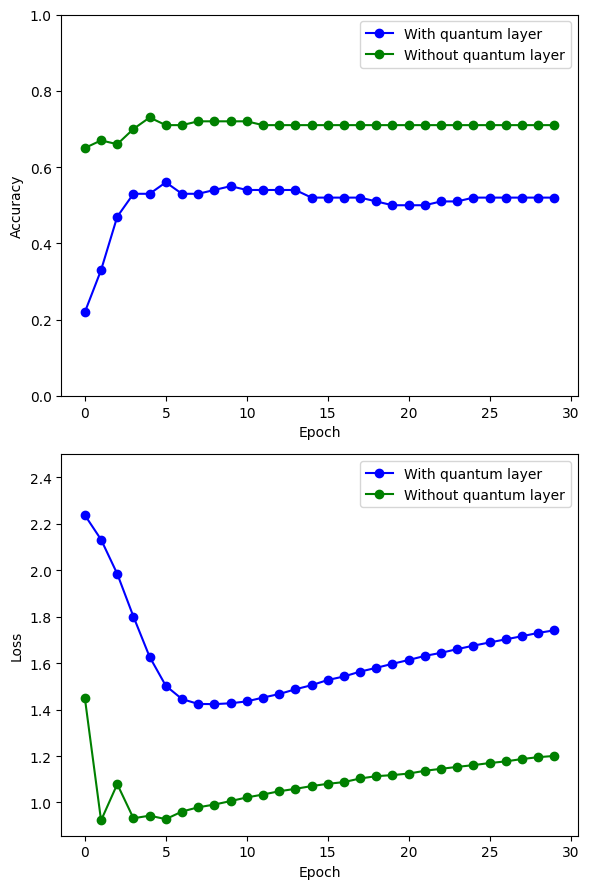

In [25]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

# References

1.  Maxwell Henderson, Samriddhi Shakya, Shashindra Pradhan, Tristan
    Cook. \"Quanvolutional Neural Networks: Powering Image Recognition
    with Quantum Circuits.\"
    [arXiv:1904.04767](https://arxiv.org/abs/1904.04767), 2019.

# About the author
